<a href="https://colab.research.google.com/github/AndyYFTao/UofT-STA414/blob/master/vae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import absolute_import
from __future__ import print_function
from future.standard_library import install_aliases
install_aliases()

import numpy as np
import os
import gzip
import struct
import array

import matplotlib.pyplot as plt
import matplotlib.image
from urllib.request import urlretrieve

In [0]:
def download(url, filename):
    if not os.path.exists('data'):
        os.makedirs('data')
    out_file = os.path.join('data', filename)
    if not os.path.isfile(out_file):
        urlretrieve(url, out_file)

def mnist():
    base_url = 'http://yann.lecun.com/exdb/mnist/'

    def parse_labels(filename):
        with gzip.open(filename, 'rb') as fh:
            magic, num_data = struct.unpack(">II", fh.read(8))
            return np.array(array.array("B", fh.read()), dtype=np.uint8)

    def parse_images(filename):
        with gzip.open(filename, 'rb') as fh:
            magic, num_data, rows, cols = struct.unpack(">IIII", fh.read(16))
            return np.array(array.array("B", fh.read()), dtype=np.uint8).reshape(num_data, rows, cols)

    for filename in ['train-images-idx3-ubyte.gz',
                     'train-labels-idx1-ubyte.gz',
                     't10k-images-idx3-ubyte.gz',
                     't10k-labels-idx1-ubyte.gz']:
        download(base_url + filename, filename)

    train_images = parse_images('data/train-images-idx3-ubyte.gz')
    train_labels = parse_labels('data/train-labels-idx1-ubyte.gz')
    test_images  = parse_images('data/t10k-images-idx3-ubyte.gz')
    test_labels  = parse_labels('data/t10k-labels-idx1-ubyte.gz')

    return train_images, train_labels, test_images, test_labels


def load_mnist():
    partial_flatten = lambda x : np.reshape(x, (x.shape[0], np.prod(x.shape[1:])))
    one_hot = lambda x, k: np.array(x[:,None] == np.arange(k)[None, :], dtype=int)
    train_images, train_labels, test_images, test_labels = mnist()
    train_images = partial_flatten(train_images) / 255.0
    test_images  = partial_flatten(test_images)  / 255.0
    train_labels = one_hot(train_labels, 10)
    test_labels = one_hot(test_labels, 10)
    N_data = train_images.shape[0]

    return N_data, train_images, train_labels, test_images, test_labels


def plot_images(images, ax, ims_per_row=5, padding=5, digit_dimensions=(28, 28),
                cmap=matplotlib.cm.binary, vmin=None, vmax=None):
    """Images should be a (N_images x pixels) matrix."""
    N_images = images.shape[0]
    N_rows = np.int32(np.ceil(float(N_images) / ims_per_row))
    pad_value = np.min(images.ravel())
    concat_images = np.full(((digit_dimensions[0] + padding) * N_rows + padding,
                             (digit_dimensions[1] + padding) * ims_per_row + padding), pad_value)
    for i in range(N_images):
        cur_image = np.reshape(images[i, :], digit_dimensions)
        row_ix = i // ims_per_row
        col_ix = i % ims_per_row
        row_start = padding + (padding + digit_dimensions[0]) * row_ix
        col_start = padding + (padding + digit_dimensions[1]) * col_ix
        concat_images[row_start: row_start + digit_dimensions[0],
                      col_start: col_start + digit_dimensions[1]] = cur_image
    cax = ax.matshow(concat_images, cmap=cmap, vmin=vmin, vmax=vmax)
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))
    return cax

def save_images(images, filename, **kwargs):
    fig = plt.figure(1)
    fig.clf()
    ax = fig.add_subplot(111)
    plot_images(images, ax, **kwargs)
    fig.patch.set_visible(False)
    ax.patch.set_visible(False)
    plt.savefig(filename)

# Implementing the Model

In [0]:
# Implements auto-encoding variational Bayes.

from __future__ import absolute_import, division
from __future__ import print_function
import autograd.numpy as np
import autograd.numpy.random as npr
import autograd.scipy.stats.norm as norm
from autograd.scipy.special import expit as sigmoid

from autograd import grad
from autograd.misc.optimizers import adam
# from data import load_mnist, save_images

In [0]:
def diag_gaussian_log_density(x, mu, log_std):
    return np.sum(norm.logpdf(x, mu, np.exp(log_std)), axis=-1)

def sample_diag_gaussian(mean, log_std, rs):
    return rs.randn(*mean.shape) * np.exp(log_std) + mean

def bernoulli_log_density(b, unnormalized_logprob):
    # returns log Ber(b | mu)
    # unnormalized_logprob is log(mu / (1 - mu)
    # b must be 0 or 1
    s = b * 2 - 1
    return -np.logaddexp(0., -s * unnormalized_logprob)

def relu(x):    return np.maximum(0, x)

In [0]:
# sample from Bernoulli.
def sample_bernoulli(p):
    return np.random.binomial(1, p)

# load and binarize the MNIST dataset.
def load_binarized_mnist(train_size=1000, test_size=1000):
    print("Loading training data...")
    N, train_x, train_labels, test_x, test_labels = load_mnist()
    def binarise(images):
        on = images > 0.5
        images = images * 0.0
        images[on] = 1.0
        return images

    print("Binarising training data...")
    # subsetting desired size
    train_x = binarise(train_x[:train_size])
    test_x = binarise(test_x[:test_size])
    train_labels = train_labels[:train_size]
    test_labels = test_labels[:test_size]
    return train_x, train_labels, test_x, test_labels
    # train_x.shape = (train_size, 784)
    # train_labels.shape = (train_size, 10) due to one hot encoding


In [0]:
# Q1(a) log of the prior over a digit's representation log p(z).
def log_prior(z):
    return diag_gaussian_log_density(z, 0, 0)


In [0]:
# Q1(b)
def init_net_params(scale, layer_sizes, rs=npr.RandomState(0)):
    """Build a (weights, biases) tuples for all layers."""
    return [(scale * rs.randn(m, n),   # weight matrix
             scale * rs.randn(n))      # bias vector
            for m, n in zip(layer_sizes[:-1], layer_sizes[1:])]

def neural_net_predict(params, inputs):
    """Params is a list of (weights, bias) tuples.
       inputs is an (N x D) matrix.
       Applies batch normalization to every layer but the last."""
    for W, b in params:
        outputs = np.dot(inputs, W) + b  # linear transformation
        inputs = np.tanh(outputs)           # nonlinear transformation
    return outputs

# MLP with a single hidden layer with 500 hidden units, and a tanh nonlinearity.
# Model hyper-parameters
latent_dim = 2
data_dim = 784  # How many pixels in each image (28x28).
gen_layer_sizes = [latent_dim, 500, data_dim]

def decoder(z, gen_params):
    # gen_params is a global variable
    return neural_net_predict(gen_params, z)

In [0]:
# Q1(c)
def log_likelihood(x, z, gen_params):
  """ Compute log likelihood log_p(x|z)"""
  bernoulli_means = decoder(z, gen_params) # parameters decoded from latent z
  likelihoods = bernoulli_log_density(x, bernoulli_means)
  return np.sum(likelihoods, axis=-1)  # Sum across pixels; likelihood for each element in batch

In [0]:
# Q1(d) log p(z, x) for a single image.
def joint_log_density(x,z, gen_params):
  return log_prior(z) + log_likelihood(x, z, gen_params)

# Amortized Approximate Inference and training

In [0]:
# Q2(a)
rec_layer_sizes = [data_dim, 500, latent_dim * 2] 

def unpack_gaussian_params(params):
    # Params of a diagonal Gaussian.
    D = np.shape(params)[-1] // 2
    mean, log_std = params[:, :D], params[:, D:]
    return mean, log_std

def nn_predict_gaussian(params, inputs):
    # Returns means and diagonal variances
    return unpack_gaussian_params(neural_net_predict(params, inputs))

def encoder(rec_params, x):
    return nn_predict_gaussian(rec_params, x)

In [0]:
# Q2(b) log likelihood of z under variational distribution.
# q_mu, q_logstd = encoder(x)
def log_q(q_mu, q_logstd, z):
    return diag_gaussian_log_density(z, q_mu, q_logstd)

In [0]:
# Q2(c)
def elbo(gen_params, rec_params, data, rs, batch_size):
    # We use a simple Monte Carlo estimate of the KL
    # divergence from the prior.
    q_means, q_log_stds = encoder(rec_params, data)
    # sample z from variational distribution
    latents = sample_diag_gaussian(q_means, q_log_stds, rs)
    # joint log likelihood of z and x under model
    joint_ll = joint_log_density(data,latents, gen_params)
    # log likelihood of z under variational distribution
    log_q_z = log_q(q_means, q_log_stds, latents)
    # data_dim = 784  # How many pixels in each image (28x28).
    elbo_estimate = np.sum(joint_ll - log_q_z) / batch_size # scalar
    return elbo_estimate 

In [0]:
# Q2(d)
def loss(gen_params, rec_params, data, rs, batch_size):
    return -elbo(gen_params, rec_params, data, rs, batch_size) # scalar

In [14]:
# Q2(e)
# Model hyper-parameters defined above: latent_dim, data_dim, gen_layer_sizes, rec_layer_sizes
# Training parameters
param_scale = 0.01
batch_size = 100
num_epochs = 100
step_size = 0.001

## Load the Data
train_x, train_labels, test_x, test_labels = load_binarized_mnist(train_size=10000, test_size=10000)

Loading training data...
Binarising training data...


In [0]:
init_gen_params = init_net_params(param_scale, gen_layer_sizes)
init_rec_params = init_net_params(param_scale, rec_layer_sizes)
combined_init_params = (init_gen_params, init_rec_params)

num_batches = int(np.ceil(len(train_x) / batch_size))

def batch_indices(iter):
    idx = iter % num_batches
    return slice(idx * batch_size, (idx+1) * batch_size)

In [0]:
def generate_from_prior(gen_params, num_samples, noise_dim, rs):
    latents = rs.randn(num_samples, noise_dim)
    return sigmoid(neural_net_predict(gen_params, latents))

def train_model_params():
    # Define training objective
    seed = npr.RandomState(0)
    # loss in writeup
    def objective(combined_params, iter):
        data_idx = batch_indices(iter)
        gen_params, rec_params = combined_params
        return -elbo(gen_params, rec_params, train_x[data_idx], seed, batch_size)

    # Get gradients of objective using autograd.
    objective_grad = grad(objective)

    print("     Epoch     |    Objective       |    Test ELBO  ")
    def print_perf(combined_params, iter, grad):
        if iter % 10 == 0:
            gen_params, rec_params = combined_params
            bound = np.mean(objective(combined_params, iter))
            message = "{:15}|{:20}|".format(iter//num_batches, bound)
            if iter % 100 == 0:
                test_bound = -elbo(gen_params, rec_params, test_x[batch_indices(iter)], seed, batch_size) #/data_dim
                message += "{:20}".format(test_bound)
            print(message)

            fake_data = generate_from_prior(gen_params, 20, latent_dim, seed)
            save_images(fake_data, 'vae_samples.png', vmin=0, vmax=1)

    # The optimizers provided can optimize lists, tuples, or dicts of parameters.
    optimized_params = adam(objective_grad, combined_init_params, step_size=step_size,
                            num_iters=num_epochs * num_batches, callback=print_perf)
    
    return optimized_params

In [0]:
# optimized_params = train_model_params()

In [0]:
# gen_params, rec_params = optimized_params

In [0]:
from google.colab import files
import pickle

def local_persist(fname, results):
  fname = fname + '.txt'
  pickle.dump(results, open(fname, 'wb'))
  files.download(fname)

# local_persist('trained_rec_params', rec_params)
# local_persist('trained_gen_params', gen_params)

In [20]:
from io import BytesIO

# function to restore from local storage
def load_from_local():
  loaded = {}
  uploaded = files.upload()
  for name in uploaded.keys():
      data = uploaded[name]
      loaded[name] = pickle.load(BytesIO(data))
  return loaded

loaded = load_from_local()
rec_params = loaded['trained_rec_params.txt']
gen_params = loaded['trained_gen_params.txt']

Saving trained_gen_params.txt to trained_gen_params.txt
Saving trained_rec_params.txt to trained_rec_params.txt


# Visualizing Posteriors and Exploring the Model

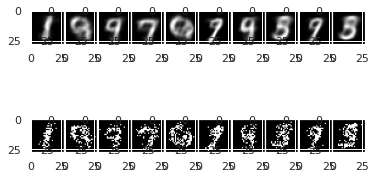

In [222]:
# Q3(a)
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import random

seed = npr.RandomState(0)
q_means, q_log_stds = encoder(rec_params, train_x)

AX = gridspec.GridSpec(2,10)
AX.update(wspace = 0.0, hspace = 0.0)

for i in range(0,10):
    # sample z from variational distribution
    z = sample_diag_gaussian(q_means, q_log_stds, seed)
    # logits of the Bernoulli means
    logits = decoder(z, gen_params)

    ber_mean = 1/(1 + np.exp(-logits)) 

    index = random.randrange(0, len(logits))
    plt.subplot(AX[0,i])
    plt.imshow(ber_mean[index].reshape(28,28), cmap='gray')

    # Sample a binary image x from this product of Bernoullis.
    images = sample_bernoulli(ber_mean)
    plt.subplot(AX[1,i])
    plt.imshow(images[index].reshape(28,28), cmap='gray')

plt.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


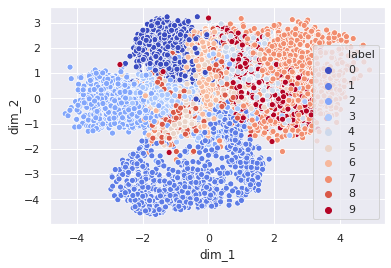

In [50]:
# Q3(b)
import seaborn as sns; sns.set()
import pandas as pd
# labels that were not one-hot encoded
_, train_labels_cat, _, test_labels_cat = mnist()
seed = npr.RandomState(0)
q_means, q_log_stds = encoder(rec_params, train_x)
mean_arr = np.array(q_means) # dim = 10000 * 2
df = pd.DataFrame()
df['dim_1'] = pd.Series(mean_arr[:,0])
df['dim_2'] = pd.Series(mean_arr[:,1])
df['label'] = pd.Series(train_labels_cat)
ax = sns.scatterplot(x="dim_1", y="dim_2", hue="label",
                     data=df, legend="full", palette="coolwarm")

In [0]:
# Q3(c)
random.seed(0)
def linear_interpolate(za, zb, alpha):
    res = alpha * np.array(za) + (1-alpha) * np.array(zb)
    return res

def sample_images(num_pairs): # of different classes
    pair_ids = []
    for i in range(num_pairs):
        id1 = random.randrange(0, len(train_x))
        id2 = random.randrange(0, len(train_x))
        while (train_labels_cat[id1] == train_labels_cat[id2]):
            id1 = random.randrange(0, len(train_x))
        pair_ids.extend([id1,id2])
    return pair_ids

pair_ids = sample_images(3)
q_means, q_log_stds = encoder(rec_params, train_x)
q_means_list, q_log_stds_list = [],[]
# [mu_1a, mu_1b, mu_2a, ..., mu_3b]
for i in range(6):
    q_means_list.append(q_means[pair_ids[i]])
    q_log_stds_list.append(q_log_stds[pair_ids[i]])

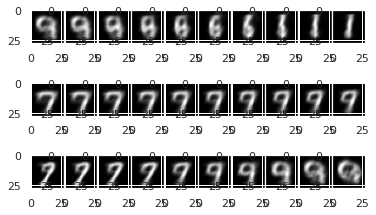

In [224]:
AX = gridspec.GridSpec(3,10)
AX.update(wspace = 0.0, hspace = 0.0)
alpha = np.linspace(0, 1, num=10)
seed = npr.RandomState(0)

for j in range(0,3):
    # sample z from variational distribution
    za = sample_diag_gaussian(q_means_list[2*j], q_log_stds_list[2*j], seed)
    zb = sample_diag_gaussian(q_means_list[2*j+1], q_log_stds_list[2*j+1], seed)

    for i in range(0,10):
        z_alpha = linear_interpolate(za, zb, alpha[i])
        # logits of the Bernoulli means
        logits = decoder(z_alpha, gen_params)

        ber_mean = 1/(1 + np.exp(-logits))

        plt.subplot(AX[j,i])
        plt.imshow(ber_mean.reshape(28,28), cmap='gray')

plt.show()

# Predicting the Bottom of Images given the Top

In [0]:
# Q4(a)
def top_half(arr, h = 28, w = 28):
    # input: 2d array (h,w)
    # lower half zero padding
    # output: 2d array (h,w)
    upper = arr[0:int(h/2),:]
    lower = np.zeros([h-int(h/2),w])
    return np.concatenate((upper,lower), axis = 0)

def log_p_top_half_given_z(image, z, gen_params):
    # image --> single image
    # z --> single z with shape (2,)
    top_half_x = top_half(image.reshape(28,28)).reshape(784,)
    return log_likelihood(top_half_x, z, gen_params) # scalar

# log p(z, top half of image x)
def joint_log_density_top_half(x, zs, gen_params):
    # zs: an array of (num_samples,2)
    # output: (num_samples,)
    return np.array([log_prior(zs[i]) + log_p_top_half_given_z(x, zs[i], gen_params) for i in range(len(zs))])

5


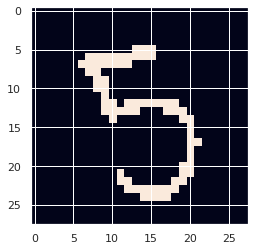

In [53]:
# Q4(b) Choose a well-modelled image
print(train_labels_cat[316])
temp = train_x[316].reshape(28,28)
plt.imshow(temp)
image_x = train_x[316]

In [0]:
# Set up plotting code
def plot_isocontours(ax, func, xlimits=[-0.5, 0.5], ylimits=[0.5, 1.5], numticks=101):
    x = np.linspace(*xlimits, num=numticks)
    y = np.linspace(*ylimits, num=numticks)
    X, Y = np.meshgrid(x, y)
    zs = func(np.concatenate([np.atleast_2d(X.ravel()), np.atleast_2d(Y.ravel())]).T)
    Z = zs.reshape(X.shape)
    plt.contour(X, Y, Z)
    ax.set_yticks([])
    ax.set_xticks([])

def plot_2d_fun(f):
    fig = plt.figure(figsize=(8,8), facecolor='white')
    ax = fig.add_subplot(111, frameon=False)
    plot_isocontours(ax, f)
    plt.plot([3, -3], [3, -3], 'b-')
    plt.show(block=True)
    plt.draw()

In [0]:
# svi
def elbo_svi(init_params, logp, num_samples, rs): # single image
    (q_means, q_log_stds) = init_params
    # mean_mat.shape = (num_samples,2)
    mean_mat = np.array([[q_means[0], q_means[1]] for i in range(num_samples)])
    log_std_mat = np.array([[q_log_stds[0], q_log_stds[1]] for i in range(num_samples)])
    # sample z from variational distribution
    latents = seed.randn(num_samples,*q_means.shape) * np.exp(log_std_mat) + mean_mat

    # joint log likelihood of z and x under model
    joint_ll = logp(latents) # (num_samples,)
    # log likelihood of z under variational distribution
    log_q_z = log_q(mean_mat, log_std_mat, latents) # (num_samples,)
    elbo_estimate = np.sum(joint_ll - log_q_z) / num_samples # scalar
    return elbo_estimate

# Conveinence function for taking gradients
def neg_elbo_svi(params, data = image_x, gen_params = gen_params, rs = seed, num_samples = 10000):
    # TODO: Write a function that takes parameters for q,
    # evidence as an array of game outcomes,
    # and returns the -elbo estimate with num_samples many samples from q
    def logp(latents):
        return joint_log_density_top_half(data, latents, gen_params)
    return -elbo_svi(params, logp, num_samples, rs)

In [0]:
def train_model_params_svi(data = image_x, gen_params = gen_params):
    # Define training objective
    def objective(params, t): # to be minimized
        return neg_elbo_svi(params)

    objective_grad = grad(objective)

    # Set up figure.
    fig = plt.figure(figsize=(8,8), facecolor='white')
    ax = fig.add_subplot(111, frameon=False)
    plt.ion()
    plt.show(block=False)

    def callback(params, t, g):
        print("Iteration {} negative elbo {}".format(t, objective(params,t)))

        plt.cla()
        def target_distribution(zs):
            return np.exp(joint_log_density_top_half(data, zs, gen_params))
        plot_isocontours(ax, target_distribution)

        (mean, log_std) = params
        def variational_contour(z):
            return np.exp(log_q(mean, log_std, z))
        plot_isocontours(ax, variational_contour)
        plt.draw()
        plt.pause(1.0/30.0)

    print("Optimizing variational parameters...")
    seed = npr.RandomState(0)
    init_mu = seed.randn(2) # Initial mu: (2,)
    init_ls = seed.randn(2) # Initial log_sigma: (2,)
    init_params = (init_mu, init_ls)

    # The optimizers provided can optimize lists, tuples, or dicts of parameters.
    optimized_params = adam(objective_grad, init_params, step_size=0.01, num_iters=1000, callback=callback)
    
    return optimized_params

In [0]:
# optimized_params_svi = train_model_params_svi(data = image_x, gen_params = gen_params)

In [203]:
(mean_svi, log_std_svi) = optimized_params_svi
print(mean_svi)
print(log_std_svi)

[0.19192287 1.17657747]
[-2.78055057 -2.07342339]


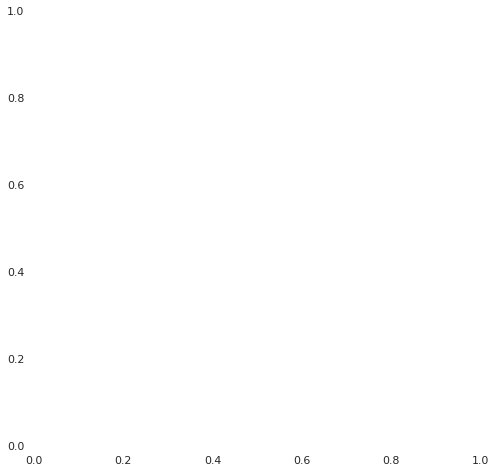

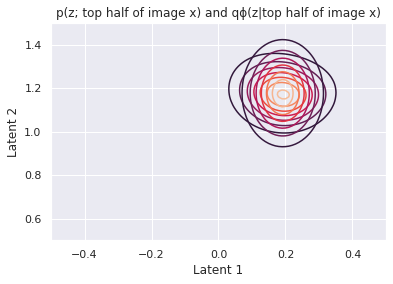

In [205]:
# the isocontours of the joint distribution p(z; top half of image x)
# and the optimized approximate posterior qϕ(z|top half of image x)
fig = plt.figure(figsize=(8,8), facecolor='white')
ax = fig.add_subplot(111, frameon=False)
plt.ion()
plt.show(block=False)
def target_distribution(zs):
    return np.exp(joint_log_density_top_half(image_x, zs, gen_params))
plot_isocontours(ax, target_distribution)

def variational_contour(z):
    return np.exp(log_q(mean_svi, log_std_svi, z))
plot_isocontours(ax, variational_contour)
plt.title('p(z; top half of image x) and qϕ(z|top half of image x)')
plt.xlabel('Latent 1')
plt.ylabel('Latent 2')
plt.draw()

In [0]:
# a sample z from the trained approximate posterior
seed = npr.RandomState(0)
z = sample_diag_gaussian(mean_svi, log_std_svi, seed)
# decoder gives Bernoulli means of p(bottom half of image x|z)
logit = decoder(z, gen_params)
# sigmoid is the inverse of logit
ber_mean = 1/(1 + np.exp(-logit)) 
# Contatenate this greyscale image to the true top of the image

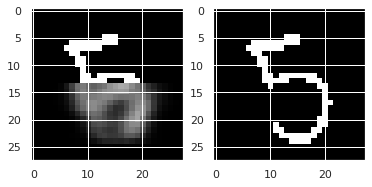

In [220]:
plt.subplot(1, 2, 1)
plt.imshow(concatenated.reshape(28,28), cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(image_x.reshape(28,28), cmap='gray')